## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

from torchmetrics import Accuracy, ConfusionMatrix, Precision, Recall, F1Score

from tqdm import tqdm


## Load data

In [4]:
def load_data():
    t = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize((256, 256)),
        ]
    )

    return datasets.ImageFolder(root="dataset", transform=t)


In [5]:
import torch
from torchvision import datasets, transforms  # tambahkan impor ini

def load_data():
    t = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize((256, 256)),
        ]
    )

    return datasets.ImageFolder(root="dataset", transform=t)


In [6]:
dataset = load_data()


In [7]:
dataset


Dataset ImageFolder
    Number of datapoints: 4217
    Root location: dataset
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
           )

In [8]:
# number of classes
NUMBER_OF_CLASSES = len(set(dataset.targets))


In [9]:
print(f"Number of classes: {NUMBER_OF_CLASSES}")


Number of classes: 4


### Exploring images

Label : cataract


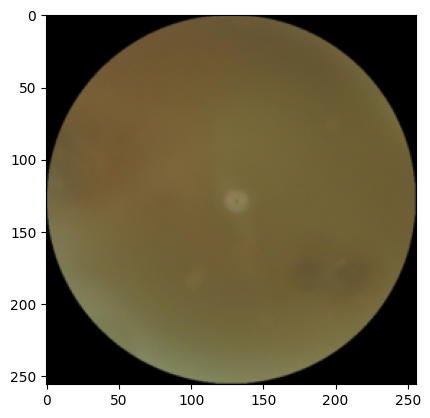

In [10]:
import matplotlib.pyplot as plt

def display_image(image, label):
    print(f"Label : {dataset.classes[label]}")
    plt.imshow(image.permute(1, 2, 0))

# Menampilkan gambar pertama dalam dataset
display_image(*dataset[0])


## Split data into train-test

In [11]:
def train_test_split(dataset, train_size, random_state=42):
    train_size = int(train_size * len(dataset))
    test_size = len(dataset) - train_size
    seed = torch.Generator().manual_seed(random_state)
    train_dataset, test_dataset = torch.utils.data.random_split(
        dataset, [train_size, test_size], generator=seed
    )

    return train_dataset, test_dataset


In [12]:
train_dataset, test_dataset = train_test_split(dataset, 0.8)


## DataLoader

In [13]:
import torch
from torch.utils.data import DataLoader  # Tambahkan impor ini

batch_size = 32
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4
)
test_dataloader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=4
)


### Visualizing the batch images

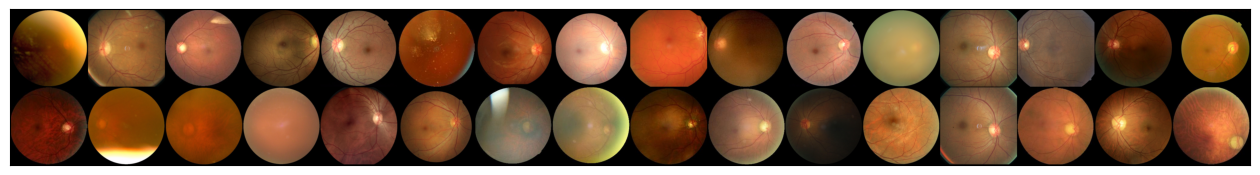

In [14]:
from torchvision.utils import make_grid  # Tambahkan impor ini
def show_batch(data_loader):
    """Plot images grid of single batch"""
    for images, labels in data_loader:
        fig, ax = plt.subplots(figsize=(16, 12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break


show_batch(train_dataloader)


## Convolutional neural network (CNN)

In [15]:
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self, NUMBER_OF_CLASSES):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=32,
                      kernel_size=3, stride=2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64,
                      kernel_size=3, stride=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.dense_layers = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(64 * 3 * 3, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, NUMBER_OF_CLASSES),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.dense_layers(x)

        return x


In [16]:
model = CNN(NUMBER_OF_CLASSES)


In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())


## Device configuration

In [18]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"
elif torch.backends.mps.is_available():
    device = "mps"


## Training function

In [19]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):

    model.to(device)
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    accuracy = Accuracy(task="multiclass",
                        num_classes=NUMBER_OF_CLASSES).to(device)
    for epoch in range(epochs):
        train_loss = []
        for inputs, targets in tqdm(train_loader, desc=f'Training... Epoch: {epoch + 1}/{epochs}'):
            # move data to GPU
            inputs, targets = inputs.to(device), targets.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward and optimize
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        # Get train loss
        train_loss = np.mean(train_loss)
        # Train accuracy
        train_accuracy = accuracy(outputs, targets)

        test_loss = []
        for inputs, targets in tqdm(test_loader, desc=f'Validating... Epoch: {epoch + 1}/{epochs}'):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss.append(loss.item())

        # Get test loss
        test_loss = np.mean(test_loss)
        # Test accuracy
        test_accuracy = accuracy(outputs, targets)

        # Save losses
        train_losses[epoch] = train_loss
        test_losses[epoch] = test_loss

        print(f"Epoch {epoch+1}/{epochs}:")
        print(
            f"Train Loss: {train_loss:.2f}, Train Accuracy: {train_accuracy:.2f}")
        print(
            f"Test Loss: {test_loss:.2f}, Test Accuracy: {test_accuracy:.2f}")
        print('-'*30)

    return train_losses, test_losses

In [20]:
train_losses, test_losses = batch_gd(
    model, criterion, optimizer, train_dataloader, test_dataloader, epochs=10
)

Training... Epoch: 1/10: 100%|██████████| 106/106 [00:47<00:00,  2.24it/s]
/Users/erikuncoro/Library/Python/3.8/lib/python/site-packages/torchmetrics/functional/classification/accuracy.py:79: UserWarning: MPS: no support for int64 for sum_out_mps, downcasting to a smaller data type (int32/float32). Native support for int64 has been added in macOS 13.3. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/ReduceOps.mm:155.)
  tp = tp.sum(dim=0 if multidim_average == "global" else 1)
Validating... Epoch: 1/10: 100%|██████████| 27/27 [00:28<00:00,  1.04s/it]


Epoch 1/10:
Train Loss: 0.89, Train Accuracy: 0.69
Test Loss: 0.70, Test Accuracy: 0.83
------------------------------


Validating... Epoch: 2/10: 100%|██████████| 27/27 [00:27<00:00,  1.01s/it]


Epoch 2/10:
Train Loss: 0.64, Train Accuracy: 0.77
Test Loss: 0.55, Test Accuracy: 0.67
------------------------------


Validating... Epoch: 3/10: 100%|██████████| 27/27 [00:26<00:00,  1.01it/s]


Epoch 3/10:
Train Loss: 0.52, Train Accuracy: 0.62
Test Loss: 0.50, Test Accuracy: 0.83
------------------------------


Validating... Epoch: 4/10: 100%|██████████| 27/27 [00:26<00:00,  1.04it/s]


Epoch 4/10:
Train Loss: 0.46, Train Accuracy: 0.92
Test Loss: 0.48, Test Accuracy: 0.83
------------------------------


Validating... Epoch: 5/10: 100%|██████████| 27/27 [00:26<00:00,  1.02it/s]


Epoch 5/10:
Train Loss: 0.44, Train Accuracy: 1.00
Test Loss: 0.44, Test Accuracy: 0.92
------------------------------


Validating... Epoch: 6/10: 100%|██████████| 27/27 [00:26<00:00,  1.03it/s]


Epoch 6/10:
Train Loss: 0.42, Train Accuracy: 0.77
Test Loss: 0.46, Test Accuracy: 0.83
------------------------------


Validating... Epoch: 7/10: 100%|██████████| 27/27 [00:26<00:00,  1.01it/s]


Epoch 7/10:
Train Loss: 0.38, Train Accuracy: 0.77
Test Loss: 0.40, Test Accuracy: 1.00
------------------------------


Validating... Epoch: 8/10: 100%|██████████| 27/27 [00:27<00:00,  1.02s/it]


Epoch 8/10:
Train Loss: 0.36, Train Accuracy: 0.69
Test Loss: 0.36, Test Accuracy: 0.92
------------------------------


Validating... Epoch: 9/10: 100%|██████████| 27/27 [00:26<00:00,  1.02it/s]


Epoch 9/10:
Train Loss: 0.34, Train Accuracy: 0.85
Test Loss: 0.40, Test Accuracy: 1.00
------------------------------


Validating... Epoch: 10/10: 100%|██████████| 27/27 [00:28<00:00,  1.06s/it]

Epoch 10/10:
Train Loss: 0.34, Train Accuracy: 1.00
Test Loss: 0.35, Test Accuracy: 1.00
------------------------------


In [50]:
pip install tqdm

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Plot the losses

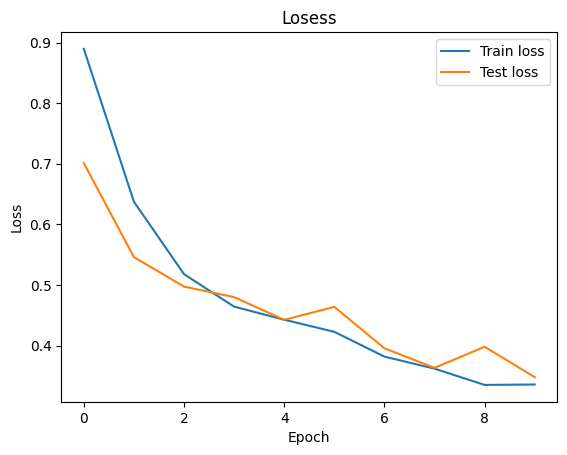

In [21]:
plt.title("Losess")
plt.plot(train_losses, label="Train loss")
plt.plot(test_losses, label="Test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Predection

In [22]:
y_pred_list = []
y_true_list = []

with torch.no_grad():
    for inputs, targets in test_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predections = torch.max(outputs, 1)

        y_pred_list.append(targets.cpu().numpy())
        y_true_list.append(predections.cpu().numpy())

targets = torch.tensor(np.concatenate(y_true_list))
preds = torch.tensor(np.concatenate(y_pred_list))


## Evaluations

### Confusion matrix

In [23]:
confmat = ConfusionMatrix(task="multiclass", num_classes=NUMBER_OF_CLASSES)
cm = confmat(preds, targets)


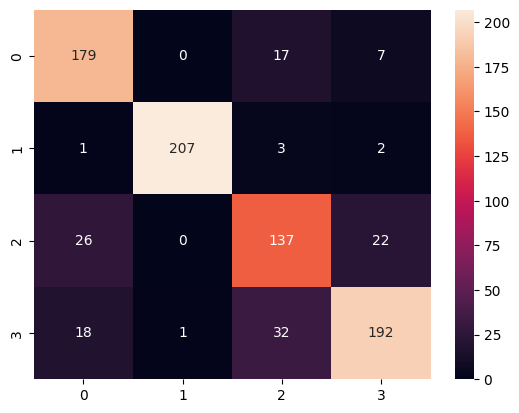

In [24]:
sn.heatmap(cm, annot=True, fmt=".0f")
plt.show()


### Accuracy

In [25]:
accuracy = Accuracy(task="multiclass", num_classes=NUMBER_OF_CLASSES).to(device)
accuracy = accuracy(preds, targets)
print(f"Accuracy: {100 * accuracy:.2f}%")


Accuracy: 84.72%


### Precision

In [26]:
precision = Precision(task="multiclass", average='micro', num_classes=NUMBER_OF_CLASSES)
precision = precision(preds, targets)
print(f"Precision: {100 * precision:.2f}%")

Precision: 84.72%


### Recall

In [27]:
recall = Recall(task="multiclass", average='micro', num_classes=NUMBER_OF_CLASSES)
recall = recall(preds, targets)
print(f"Recall: {100 * recall:.2f}%")

Recall: 84.72%


### F1-score

In [28]:
f1 = F1Score(task="multiclass", num_classes=NUMBER_OF_CLASSES)
f1 = f1(preds, targets)
print(f"F1 Score: {100 * f1:.2f}%")

F1 Score: 84.72%
